In [6]:
# A5

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch as t
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("cleaned_compas.csv")
df = df.drop(columns=["Unnamed: 0"])

In [34]:
df

,age_cat,priors_count,two_year_recid,race_cat,gender_cat,charge_cat,length_stay
0,0.5,0.0,1,0,0,1,0.5
1,0.0,1.0,1,0,0,1,0.0
2,0.5,1.0,1,1,0,1,0.0
3,0.5,0.0,0,1,1,0,0.0
4,0.0,0.5,1,1,0,1,0.0
...,...,...,...,...,...,...,...
5910,0.5,0.0,1,0,0,0,0.0
5911,0.0,0.0,0,0,0,1,0.0
5912,0.0,0.0,0,0,0,1,0.0
5913,0.0,0.0,0,0,0,1,0.0


In [35]:
# Data splitting: Training:Testing:Validation=5:1:1
df_a = df[(df['race_cat'] == 0)]
df_c = df[(df['race_cat'] == 1)]
df_a = df_a.drop(columns=["race_cat"])
df_c = df_c.drop(columns=["race_cat"])

X_a = df_a.drop(columns = ['two_year_recid']).copy()
X_c = df_c.drop(columns = ['two_year_recid']).copy()
y_a = df_a['two_year_recid']
y_c = df_c['two_year_recid']

X_a_train, X_a_tv, y_a_train, y_a_tv = train_test_split(X_a, y_a, train_size=5/7)
X_a_test, X_a_valid, y_a_test, y_a_valid = train_test_split(X_a_tv,y_a_tv, test_size=1/2)
X_c_train, X_c_tv, y_c_train, y_c_tv = train_test_split(X_c, y_c, train_size=5/7)
X_c_test, X_c_valid, y_c_test, y_c_valid = train_test_split(X_c_tv,y_c_tv, test_size=1/2)

X_train = pd.concat([X_a_train, X_c_train])
y_train = pd.concat([y_a_train, y_c_train])
X_test = pd.concat([X_a_test, X_c_test])
y_test = pd.concat([y_a_test, y_c_test])
X_valid = pd.concat([X_a_valid, X_c_valid])
y_valid = pd.concat([y_a_valid, y_c_valid])

In [36]:
X_a_train = t.tensor(np.array(X_a_train)).to(t.float32)
y_a_train = t.from_numpy(np.array(y_a_train).astype('float32')).reshape(X_a_train.shape[0], 1)
X_c_train = t.tensor(np.array(X_c_train)).to(t.float32)
y_c_train = t.from_numpy(np.array(y_c_train).astype('float32')).reshape(X_c_train.shape[0], 1)

X_a_test = t.tensor(np.array(X_a_test)).to(t.float32)
y_a_test = t.from_numpy(np.array(y_a_test).astype('float32')).reshape(X_a_test.shape[0], 1)
X_c_test = t.tensor(np.array(X_c_test)).to(t.float32)
y_c_test = t.from_numpy(np.array(y_c_test).astype('float32')).reshape(X_c_test.shape[0], 1)

X_a_valid = t.tensor(np.array(X_a_valid)).to(t.float32)
y_a_valid = t.from_numpy(np.array(y_a_valid).astype('float32')).reshape(X_a_valid.shape[0], 1)
X_c_valid = t.tensor(np.array(X_c_valid)).to(t.float32)
y_c_valid = t.from_numpy(np.array(y_c_valid).astype('float32')).reshape(X_c_valid.shape[0], 1)



In [37]:
# We used 0.5 as threshold

def accuracy(Model_a, Model_c, X_a_train, y_a_train, X_c_train, y_c_train):
    y_a_pred = (Model_a(X_a_train) >= 0.5)
    y_c_pred = (Model_c(X_c_train) >= 0.5)
    acc_a  = t.sum(y_a_pred.flatten() == y_a_train.flatten()) / X_a_train.shape[0]
    acc_c  = t.sum(y_c_pred.flatten() == y_c_train.flatten()) / X_c_train.shape[0]
    accuracy = (acc_c + acc_a) / 2
    calibration = t.abs(acc_a - acc_c)
    return round(accuracy.item(), 4), round(calibration.item(), 4)
    print("Accuracy : %.3f" % (accuracy * 100) + '%')
    print("Calibration : %.3f" % (calibration * 100) + '%')

def CVS(Model_a, Model_c, X_a_train, X_c_train):
    y_a_pred = (Model_a(X_a_train) >= 0.5)
    y_c_pred = (Model_c(X_c_train) >= 0.5)
    resid_a = t.sum(y_a_pred == True) / X_a_train.shape[0]
    resid_c = t.sum(y_c_pred == True) / X_c_train.shape[0]
    CVScore = t.abs(resid_a - resid_c)
    return round(CVScore.item(), 4)

In [38]:
class LogisticRegression(nn.Module):
    def __init__(self,df):
        super(LogisticRegression, self).__init__()
        self.w = nn.Linear(df.shape[1], out_features=1, bias=True)
        self.sigmod = nn.Sigmoid()
    def forward(self, x):
        w = self.w(x)
        output = self.sigmod(w)
        return output

In [39]:
class PRLoss():
    def __init__(self, eta=1.0):
        super(PRLoss, self).__init__()
        self.eta = eta
    def forward(self, output_a, output_c):
        # Approximating the true distribution of data by the sample distribution
        # eqn(9) in paper: hat{Pr}[y|s] = sum{(xi,si), s.t. si=s} Model(y|xi,s;theta) / |D[xs]|
        #D[xs]
        N_a = t.tensor(output_a.shape[0])
        N_c = t.tensor(output_c.shape[0])
        D_xs = t.stack((N_a, N_c), axis=0)
        # Pr[y|s]
        y_pred_a = t.sum(output_a)
        y_pred_c = t.sum(output_c)
        P_y_s = t.stack((y_pred_a, y_pred_c), axis=0) / D_xs
        # eqn(10) in paper: hat{Pr}[y] = sum{(xi,si)} Model(y|xi,si;theta) / |D[xs]|
        P = t.cat((output_a, output_c), 0)
        P_y = t.sum(P) / (X_a_train.shape[0]+X_c_train.shape[0])
        # P(yi|si)
        P_1_1 = t.log(P_y_s[1]) - t.log(P_y)
        P_0_1 = t.log(1-P_y_s[1]) - t.log(1-P_y)
        P_1_0 = t.log(P_y_s[0]) - t.log(P_y)
        P_0_0 = t.log(1-P_y_s[0]) - t.log(1-P_y)
        # eqn(11) in paper: prejudice remover regularizer R_PR(D, theta)
        # R_PR = sum{xi,si}sum{y} Model(y|xi,s;theta) * ln(hat{Pr}[y|si]/hat{Pr}[y])
        R_PR_1_1 = output_c * P_1_1
        R_PR_0_1 =(1- output_c) * P_0_1
        R_PR_1_0 = output_a * P_1_0
        R_PR_0_0 = (1- output_a) * P_0_0
        R_PR = t.sum(R_PR_1_1) + t.sum(R_PR_0_1) + t.sum(R_PR_1_0) + t.sum(R_PR_0_0)
        R_PR = self.eta * R_PR
        return R_PR

In [50]:
class PRLR():
    def __init__(self, eta = 0.0, epochs = 300, lr = 0.01):
        super(PRLR, self).__init__()
        self.eta = eta
        self.epochs = epochs
        self.lr = lr
    def fit(self, X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
            X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test):
        model_a = LogisticRegression(X_a_train)
        model_c = LogisticRegression(X_c_train)
        criterion = nn.BCELoss(reduction='sum')
        PI = PRLoss(eta=self.eta) # Prejudice index
        epochs = self.epochs
        optimizer = t.optim.Adam(list(model_c.parameters())+list(model_a.parameters()), self.lr, weight_decay=1e-5)
        train_losses = []
        valid_losses = []
        for epoch in range(epochs):
            model_c.train()
            model_a.train()
            optimizer.zero_grad()
            output_a = model_a(X_a_train)
            output_c = model_c(X_c_train)
            logloss = criterion(output_a, y_a_train) + criterion(output_c, y_c_train)
            PRloss = PI.forward(output_a, output_c)
            loss = (PRloss + logloss)/5
            loss.backward()
            optimizer.step()
            train_losses.append(loss.detach().numpy())
            output_a = model_a(X_a_valid)
            output_c = model_c(X_c_valid)
            logloss = criterion(output_a, y_a_valid) + criterion(output_c, y_c_valid)
            PRloss = PI.forward(output_a, output_c)
            loss = PRloss + logloss
            valid_losses.append(loss.detach().numpy())
        model_a.eval()
        model_c.eval()
        acc = accuracy(model_a, model_c, X_a_train, y_a_train, X_c_train, y_c_train)
        acc_valid = accuracy(model_a, model_c, X_a_valid, y_a_valid, X_c_valid, y_c_valid)
        acc_test = accuracy(model_c, model_a, X_a_test, y_a_test, X_c_test, y_c_test)
        plt.plot(list(range(epochs)), train_losses, label="train loss")
        plt.plot(list(range(epochs)), valid_losses, label="validation loss")
        plt.legend(loc="upper left")
        plt.xlabel('Number of Epochs')
        plt.ylabel('Loss')
        plt.show()
        cvs = CVS(model_a, model_c, X_a_train, X_c_train)
        return acc, acc_valid, acc_test, cvs

eta Value: 0


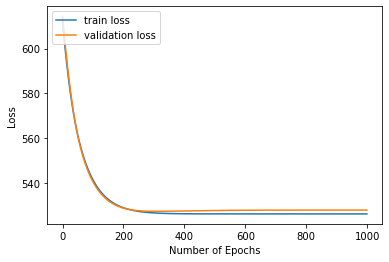

eta Value: 1


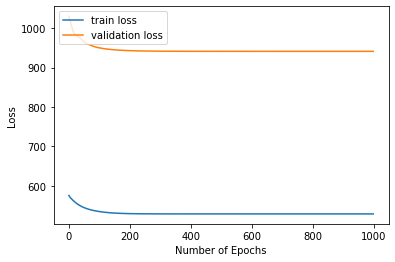

eta Value: 2


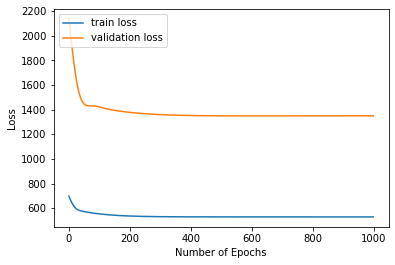

eta Value: 3


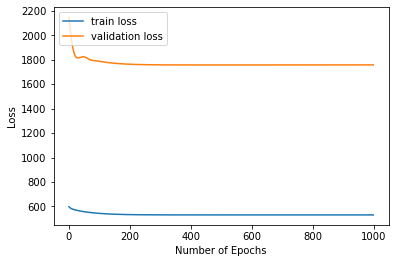

eta Value: 4


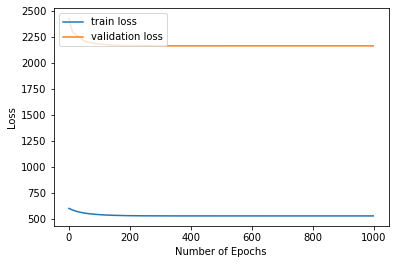

eta Value: 5


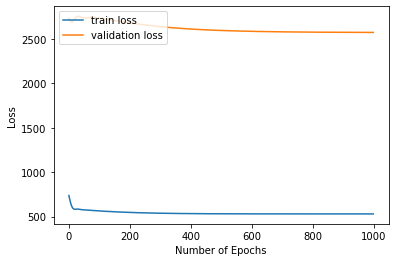

eta Value: 6


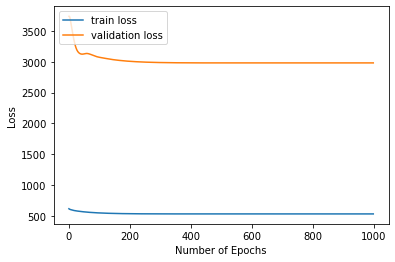

eta Value: 8


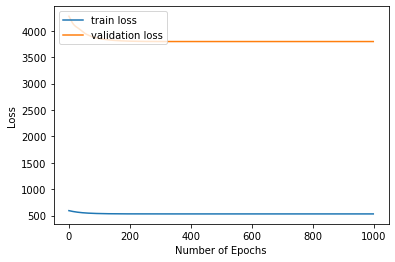

eta Value: 10


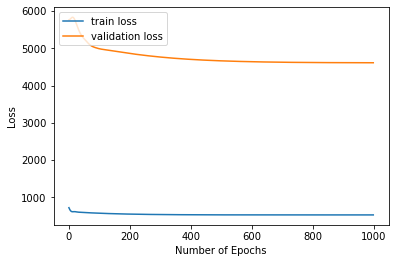

eta Value: 15


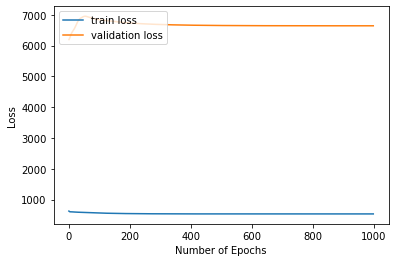

In [58]:
eta_value = [0, 1, 2, 3, 4, 5, 6, 8, 10, 15]
accur = list()
accur_valid = list()
accur_test = list()
cvscore = list()
for i in range(0, len(eta_value)):
    print("eta Value: %d" % eta_value[i])
    PR = PRLR(eta = eta_value[i], epochs = 1000, lr = 0.01)
    acc_eta, acc_valid_eta, acc_test_eta, cvs = PR.fit(X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
                                                       X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test)
    accur.append(acc_eta)
    accur_valid.append(acc_valid_eta)
    accur_test.append(acc_test_eta)
    cvscore.append(cvs)

In [57]:
print(eta_value)
print(eta_acc_train)
print(eta_acc_valid)
print(eta_acc_test)

[0, 1, 2, 3, 4, 5, 6, 8, 10, 15]
[0.6602, 0.659, 0.6567, 0.6573, 0.6561, 0.6481, 0.6481, 0.6481, 0.6481, 0.6481]
[]
[0.6662, 0.6627, 0.6617, 0.6691, 0.6676, 0.6557, 0.6557, 0.6557, 0.6557, 0.6557]


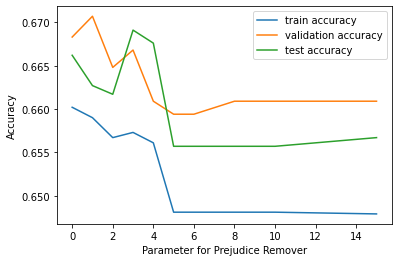

In [59]:
eta_acc_train = [x[0] for x in accur]
eta_acc_valid = [x[0] for x in accur_valid]
eta_acc_test = [x[0] for x in accur_test]
plt.plot(eta_value, eta_acc_train, label="train accuracy")
plt.plot(eta_value, eta_acc_valid, label="validation accuracy")
plt.plot(eta_value, eta_acc_test, label="test accuracy")
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")
plt.show()

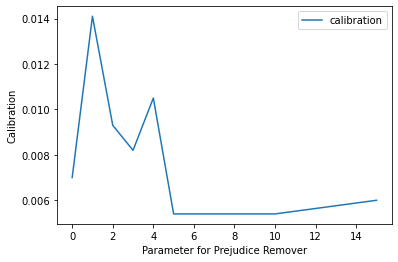

In [60]:
eta_cal_train = [x[1] for x in accur]
plt.plot(eta_value, eta_cal_train, label="calibration")
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('Calibration')
plt.legend(loc="upper right")
plt.show()

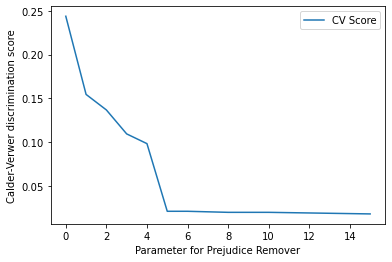

In [61]:
plt.plot(eta_value, cvscore, label="CV Score")
plt.xlabel('Parameter for Prejudice Remover')
plt.ylabel('Calder-Verwer discrimination score')
plt.legend(loc="upper right")
plt.show()

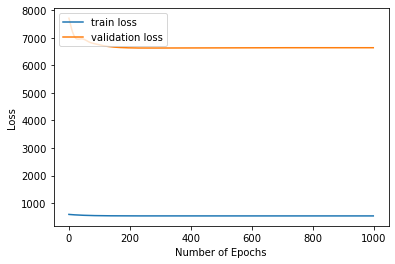

((0.6479, 0.006), (0.6609, 0.0253), (0.6567, 0.0252), 0.0184)

In [63]:
# Final model
PR_eta1 = PRLR(eta = 5, epochs = 1000, lr = 0.01)
PR.fit(X_a_train, y_a_train, X_c_train, y_c_train, X_a_valid, y_a_valid, 
         X_c_valid, y_c_valid, X_a_test, y_a_test, X_c_test, y_c_test)